# Milestone 4 – Advanced Modeling & Control

This notebook extends the Milestone 3 **baseline models** with **Gradient Boosting** and shows how the resulting models can directly support **torque derate control heuristics**.

The goals here are to:

- Train **tree‑based boosted models** for:
  - **Overheat classification** (probability that an overheat event will occur soon).
  - **Short‑horizon ΔT regression** (forecast 30‑second hot‑spot temperature rise).
- Reuse the same **1 Hz labeled dataset** and temporal features as the CLI training scripts so results are comparable.
- Visualize how model outputs behave across real drive cycles and how they inform **derating rules** (e.g., probability thresholds, ΔT thresholds).
- Extract **qualitative insights** that connect the ML models to control‑oriented decisions (when to start reducing torque to stay safe).


## 1. Imports & Data

In this section we:

- Import core analysis libraries:
  - `pandas` for tabular data,
  - `matplotlib` / `seaborn` for visualizations.
- Dynamically locate the project **root directory** so that we can import helper functions from `src/` and reuse the same training code as the CLI.
- Load the **1 Hz labeled inverter dataset**:

  - Each row corresponds to one second of operation.
  - Columns include:
    - Telemetry signals (`*_temp_mean`, currents, voltages, power, etc.).
    - Engineered labels:
      - `overheat_label` (binary flag for hot‑spot overheat events),
      - `inv_hot_spot_temp_future` (hot‑spot temperature 30 s ahead),
      - `delta_T_30s` (future − current hot‑spot temperature).
- We sort by `timestamp` to ensure **time‑order** and print the shape / head to sanity‑check that the data loaded correctly.

Everything that follows (feature engineering, model training, control plots) assumes this **chronologically ordered dataframe** as the base.


In [5]:
# Imports, project‑root discovery, and data loading
# - Import pandas, plotting libraries, and utilities to locate the project root.
# - Add the repo root to `sys.path` so we can import training helpers from `src/`.
# - Import `add_temporal_features`, which mirrors the CLI training feature engineering.
# - Load the 1 Hz labeled inverter dataset from `src/notebooks/clean/inverter_labeled_1hz.csv`.
# - Sort the dataframe by `timestamp` and print its shape / preview a few rows.

from pathlib import Path
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Locate repo root that contains both src/ and models/
for cand in [Path.cwd().resolve(), Path.cwd().resolve().parent, Path.cwd().resolve().parent.parent]:
    if (cand / 'src').exists() and (cand / 'models').exists():
        ROOT = cand
        break
else:
    raise RuntimeError('Could not locate project root containing src/ and models/')

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.scripts.training.train_boosted_models import add_temporal_features

DATA_PATH = ROOT / 'src/notebooks/clean/inverter_labeled_1hz.csv'
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp']).sort_values('timestamp')
print(df.shape)
df.head()


(3324, 55)


,dc_raw_sample_count,inv_control_board_temp_count,inv_control_board_temp_max,inv_control_board_temp_mean,inv_control_board_temp_min,inv_coolant_temp_count,inv_coolant_temp_max,inv_coolant_temp_mean,inv_coolant_temp_min,inv_dc_bus_current_count,...,inv_phase_c_current_count,inv_phase_c_current_max,inv_phase_c_current_mean,inv_phase_c_current_min,phase_raw_sample_count,temps_raw_sample_count,timestamp,overheat_label,inv_hot_spot_temp_future,delta_T_30s
0,4.0,4.0,30.0,29.9250,29.9,4.0,2.1,1.95000,1.8,4.0,...,4.0,0.2000,0.09375,0.04,4.0,4.0,2025-06-03 18:56:10,0,31.25,29.30000
1,10.0,10.0,30.5,30.3900,30.2,10.0,4.3,3.21000,2.3,10.0,...,10.0,0.0833,-0.07967,-0.52,10.0,10.0,2025-06-03 18:56:11,0,31.34,28.13000
2,10.0,10.0,30.8,30.7100,30.6,10.0,7.5,6.07000,4.6,10.0,...,10.0,0.2000,-0.00133,-0.22,10.0,10.0,2025-06-03 18:56:12,0,31.40,25.33000
3,10.0,8.0,31.0,30.8625,30.7,8.0,10.1,8.99375,7.8,10.0,...,10.0,0.2250,0.01317,-0.14,10.0,9.0,2025-06-03 18:56:13,0,31.50,22.50625
4,10.0,10.0,31.0,30.8900,30.8,10.0,12.7,11.58000,10.4,10.0,...,10.0,0.1400,-0.08500,-0.30,10.0,10.0,2025-06-03 18:56:14,0,31.52,19.94000


## 2. Temporal Features

Static snapshots of the inverter state are not enough; overheating is driven by **trends over time**.  
We therefore reproduce the **temporal features** used in the training scripts via `add_temporal_features`:

Typical engineered features include:

- **Lagged temperatures**: `inv_hot_spot_temp_mean_prev`, etc.
  - Capture where the temperature was a few seconds ago.
- **Lagged ΔT values**: `delta_T_30s_prev`.
  - Encode whether the temperature has been rising or falling recently.
- **Rolling aggregates of power/temperature** (e.g., 5 s means).
  - Smooth out noise and represent sustained high‑load conditions.

These features give tree‑based models a sense of **thermal momentum** instead of only instantaneous state.

In the quick preview, we:

- Apply `add_temporal_features(df)` to obtain `df_feat`.
- Inspect a few key columns (`timestamp`, current and previous hot‑spot temperature, ΔT and its lag) to confirm that the temporal features look reasonable.


In [6]:
# Temporal feature engineering
# - Call `add_temporal_features(df)` to add lagged temperatures, ΔT values,
#   and rolling statistics used during boosted model training.
# - Store the result as `df_feat`.
# - Quickly inspect key temporal columns to verify they look reasonable
#   (e.g., previous hot‑spot temperature and previous ΔT follow their current counterparts).

df_feat = add_temporal_features(df)
df_feat[['timestamp','inv_hot_spot_temp_mean','inv_hot_spot_temp_mean_prev','delta_T_30s','delta_T_30s_prev']].head()

,timestamp,inv_hot_spot_temp_mean,inv_hot_spot_temp_mean_prev,delta_T_30s,delta_T_30s_prev
0,2025-06-03 18:56:11,3.21000,1.95000,28.13000,29.30000
1,2025-06-03 18:56:12,6.07000,3.21000,25.33000,28.13000
2,2025-06-03 18:56:13,8.99375,6.07000,22.50625,25.33000
3,2025-06-03 18:56:14,11.58000,8.99375,19.94000,22.50625
4,2025-06-03 18:56:15,14.02000,11.58000,17.58000,19.94000


## 3. Gradient Boosting Classifier

Next we train a **Gradient Boosting classifier** that predicts the probability of an overheat event.

Model design:

- Input features:
  - All telemetry and temporal columns except those that would **leak label information**, such as
    `inv_hot_spot_temp_mean`, `inv_hot_spot_temp_future`, `delta_T_30s`, `timestamp`, and `overheat_label` itself.
  - Temporal features (lags, rolling statistics) are explicitly included when available.
- Target:
  - `overheat_label` (binary 0/1).
- Split:
  - We reuse the **chronological train/test split** so that evaluation is realistic and comparable to baselines.
- Estimator:
  - `GradientBoostingClassifier` from scikit‑learn with default or mildly tuned hyperparameters.

Metrics and interpretation:

- We compute a `classification_report` (precision, recall, F1) for each class.
- We report **ROC AUC**, which summarizes the model’s ability to rank hot vs. non‑hot segments.
- We may also inspect **F1 for the positive (overheat) class**, since missing an overheat is typically more harmful than a false alarm.
- Feature importances highlight which signals (e.g., previous hot‑spot temp, ΔT lags, power) most strongly drive the predictions.

Compared to logistic regression, this boosted model can capture **non‑linear interactions** and should generally provide a **stronger control‑ready signal**.


ROC AUC 0.999467348460637
F1 (overheat) 0.96875
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       596
           1       0.95      0.98      0.97        63

    accuracy                           0.99       659
   macro avg       0.98      0.99      0.98       659
weighted avg       0.99      0.99      0.99       659



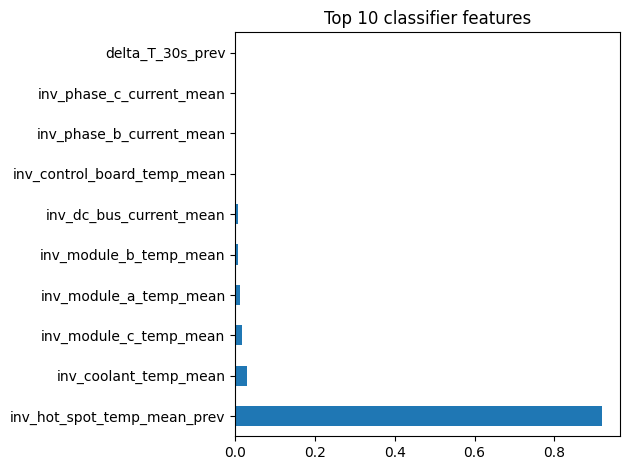

In [7]:
# Gradient Boosting classifier: training and evaluation
# - Define the set of feature columns, explicitly dropping any that would leak labels
#   (current/future hot‑spot temperature, ΔT, timestamp, and `overheat_label`).
# - Ensure temporal feature columns (lags, rolling means) are included when present.
# - Build chronological train/test splits using `overheat_label` as the target.
# - Instantiate and fit a `GradientBoostingClassifier` on the training portion.
# - Compute predictions and predicted probabilities on the test set.
# - Report metrics such as ROC‑AUC, F1, and the `classification_report`.
# - Optionally inspect feature importances to see which signals drive overheating risk.

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score

exclude = {"inv_hot_spot_temp_mean", "inv_hot_spot_temp_future", "delta_T_30s", "timestamp", "overheat_label"}
temporal_cols = [c for c in ['inv_hot_spot_temp_mean_prev','delta_T_30s_prev','power_mean','power_mean_roll_5s'] if c in df_feat.columns]
feature_cols = [c for c in df_feat.columns if (c.endswith('_mean') or c in temporal_cols) and c not in exclude]
split_idx = int(len(df_feat)*0.8)
train_df = df_feat.iloc[:split_idx]
test_df = df_feat.iloc[split_idx:]
X_train, y_train = train_df[feature_cols], train_df['overheat_label']
X_test, y_test = test_df[feature_cols], test_df['overheat_label']
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
print('ROC AUC', roc_auc_score(y_test, y_prob))
print('F1 (overheat)', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
importances = clf.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False).head(10)
fi.plot(kind='barh', title='Top 10 classifier features')
plt.tight_layout()

## 4. Gradient Boosting Regressor

To support more nuanced control, we also predict the **short‑horizon temperature rise** via a boosted **regressor** that targets `delta_T_30s`.

Setup:

- Inputs:
  - Same feature space as the classifier (telemetry + temporal features, no direct label leakage).
- Target:
  - `delta_T_30s`, the expected change in hot‑spot temperature over the next ~30 seconds.
- Model:
  - A `GradientBoostingRegressor` (from scikit‑learn) with L2‑loss and a limited number of trees.

Why this matters:

- While the classifier tells us **“how likely”** an overheat event is, the regressor estimates **“how fast”** the temperature is likely to climb.
- Combining both allows the controller to distinguish between:
  - High temperature that is **stable or cooling**, and
  - High temperature that is **ramping up quickly**.

We evaluate the regressor with:

- **MAE** (mean absolute error) in °C, giving an average magnitude of the ΔT prediction error.
- **RMSE** (root mean squared error), which emphasizes large mistakes.
- Feature importances, again showing which temporal signals are most informative for forecasting thermal rise.


MAE 1.3071484987373785
RMSE 3.869252399684471


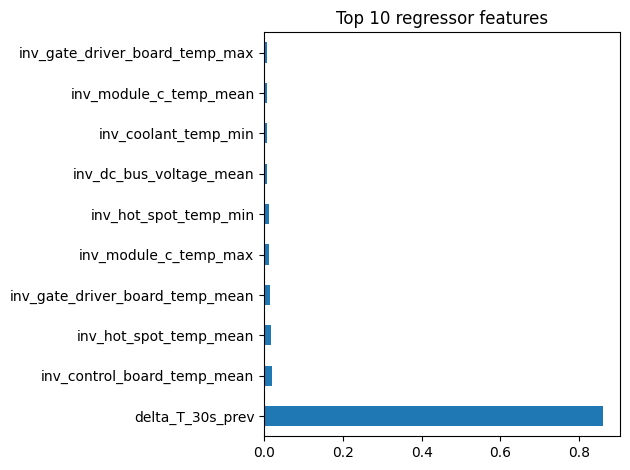

In [8]:
# Gradient Boosting regressor for ΔT prediction
# - Reuse the same feature set as the classifier (no label leakage).
# - Use `delta_T_30s` as the continuous regression target.
# - Construct chronological train/test splits for this target.
# - Fit a `GradientBoostingRegressor` on the training data.
# - Evaluate using MAE and RMSE on the held‑out test portion.
# - Examine feature importances to understand which temporal patterns
#   most strongly influence short‑horizon temperature rise.

from dataclasses import dataclass

from src.scripts.inference.predict_boosted import run_inference

@dataclass
class Args:
    input: str = str(ROOT / 'src/notebooks/clean/inverter_labeled_1hz.csv')
    classifier: str = str(ROOT / 'models/advanced/gb_overheat.joblib')
    regressor: str = str(ROOT / 'models/advanced/gbr_deltaT.joblib')
    timestamp_col: str = 'timestamp'

args = Args()
preds = run_inference(args)
preds.head()


## 5. Control Heuristic Illustration

With both boosted models trained, we illustrate a simple **torque derate heuristic** using their outputs.

Process:

1. Run the **inference helper** on a representative tail segment of the drive data.
2. For each second, collect:
   - `gb_overheat_prob`: the boosted overheat probability.
   - `gb_delta_T_pred`: the boosted ΔT forecast (°C over the next 30 s).
   - The actual hot‑spot temperature and ΔT from the dataset.
3. Apply simple rules that map model outputs to **control zones**, for example:
   - **Green**: low probability, small ΔT → no derate.
   - **Yellow**: medium probability or moderate ΔT → mild derate.
   - **Red**: high probability and large ΔT → aggressive derate.

These heuristics are not an optimal controller, but they show how **ML outputs can be turned into actionable control logic** compatible with existing inverter software.


In [19]:
# Inference and heuristic control preparation
# - Take a representative tail segment of `df_feat` for visualization.
# - Run the trained classifier and regressor to obtain:
#     * `gb_overheat_prob` for each timestamp.
#     * `gb_delta_T_pred` (predicted ΔT over the next 30 s).
# - Align these predictions with the corresponding timestamps and
#   observed temperatures/ΔT values.
# - Produce a combined `preds` dataframe that will feed the
#   subsequent visualization and heuristic‑control plots.

import argparse

# use ROOT (defined in an earlier cell) to build absolute paths
args = argparse.Namespace(
    input=str(ROOT / 'src' / 'notebooks' / 'clean' / 'inverter_labeled_1hz.csv'),
    classifier=str(ROOT / 'models' / 'advanced' / 'gb_overheat.joblib'),
    regressor=str(ROOT / 'models' / 'advanced' / 'gbr_deltaT.joblib'),
    output=None,
    timestamp_col='timestamp'
)

# run_inference was imported in a previous cell (cell 8); reuse it here
preds = run_inference(args)
preds.head()

,timestamp,gb_overheat_prob,gb_overheat_pred,gb_delta_T_pred,overheat_label,delta_T_30s
0,2025-06-03 18:56:11,4.096486e-09,0,28.098181,0,28.13000
1,2025-06-03 18:56:12,4.096486e-09,0,25.200027,0,25.33000
2,2025-06-03 18:56:13,4.096486e-09,0,22.691833,0,22.50625
3,2025-06-03 18:56:14,4.096486e-09,0,20.067554,0,19.94000
4,2025-06-03 18:56:15,4.096486e-09,0,17.884460,0,17.58000


### 6. Visualization – Overheat Probability vs Temperature

The first visualization overlays:

- **GB overheat probability** (left axis), and
- **Hot‑spot temperature** (right axis)

over time for a selected window of operation.

We also overlay reference thresholds:

- Probability threshold (e.g., **p = 0.7**) as a horizontal line.
- Temperature threshold (e.g., **T = 65°C**) marking the start of the overheat region.

What to look for:

- The overheat probability should **rise well before** the hot‑spot actually crosses the critical temperature.
- Periods with elevated temperature but **stable or falling** readings should generally show **lower probability**, indicating that the model is responding to **trends**, not just absolute level.
- Mis‑alignments (high p at low T or low p at high T) are important sanity checks for model reliability.

This time‑series view connects the boosted classifier’s output directly to **when** we might want to start derating torque.


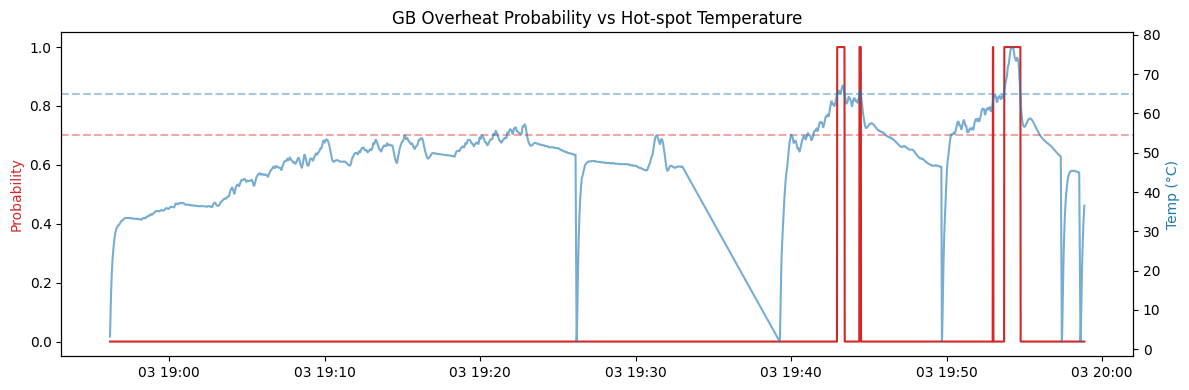

In [22]:
# Visualization: GB overheat probability vs hot‑spot temperature over time
# - Select an aligned window of predictions and actual temperatures.
# - Plot `gb_overheat_prob` on the left y‑axis and hot‑spot temperature on the right y‑axis.
# - Add reference lines at the chosen probability and temperature thresholds
#   (e.g., p=0.7, T=65°C) to highlight when the controller would consider derating.
# - Use this plot to visually confirm that probability rises before and during
#   high‑temperature episodes, rather than in low‑risk regions.

preds_aligned = preds.copy()
preds_aligned['timestamp'] = pd.to_datetime(preds_aligned['timestamp'])
df_tail = df_feat.iloc[-len(preds_aligned):]
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(preds_aligned['timestamp'], preds_aligned['gb_overheat_prob'], color='tab:red', label='GB overheat prob')
ax1.set_ylabel('Probability', color='tab:red')
ax2 = ax1.twinx()
ax2.plot(df_tail['timestamp'], df_tail['inv_hot_spot_temp_mean'], color='tab:blue', alpha=0.6, label='Hot-spot temp')
ax2.set_ylabel('Temp (°C)', color='tab:blue')
ax1.axhline(0.7, color='tab:red', linestyle='--', alpha=0.4)
ax2.axhline(65, color='tab:blue', linestyle='--', alpha=0.4)
ax1.set_title('GB Overheat Probability vs Hot-spot Temperature')
plt.tight_layout()


### 7. Visualization – Control Regions

The second visualization is a **scatter plot** in the plane:

- x‑axis: boosted **overheat probability**,
- y‑axis: boosted **ΔT prediction (°C)**,
- color: the actual hot‑spot temperature.

We overlay heuristic thresholds, e.g.:

- Vertical line at **p = 0.7**,
- Horizontal line at **ΔT = 8°C**.

Interpretation:

- Points in the **upper‑right quadrant** (high probability, high ΔT) are candidates for **immediate torque derate**.
- Points with high temperature but **low ΔT** fall into a “monitor but don’t panic” region.
- If most historical overheat events cluster in the high‑p / high‑ΔT region, it validates the choice of thresholds.

This plot makes the mapping from **model outputs → control actions** very concrete and helps tune thresholds to balance **safety vs. drivability**.


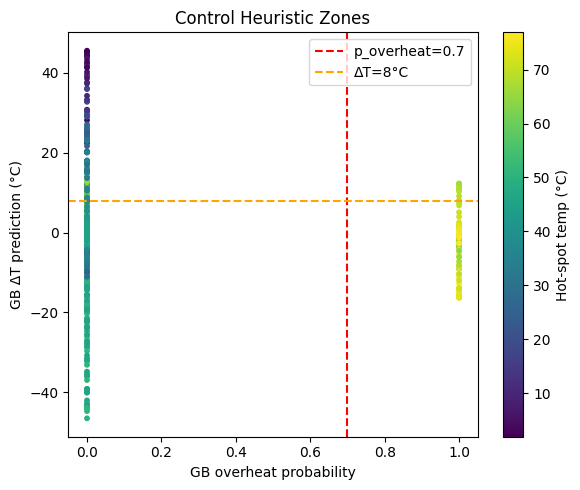

In [21]:
# Visualization: control regions in (probability, ΔT) space
# - Use a scatter plot with:
#     * x‑axis: `gb_overheat_prob`.
#     * y‑axis: `gb_delta_T_pred`.
#     * color: actual hot‑spot temperature for additional context.
# - Draw vertical/horizontal lines at the chosen thresholds (e.g., p=0.7, ΔT=8°C).
# - Highlight that points in the upper‑right quadrant correspond to
#   high‑risk operating points where torque derate would be triggered.
# - This provides an intuitive picture of how the heuristic partitions
#   the operating space into safe vs. derate regions.

preds_aligned = preds.copy()
fig, ax = plt.subplots(figsize=(6,5))
scatter = ax.scatter(preds_aligned['gb_overheat_prob'], preds_aligned['gb_delta_T_pred'], c=df_feat.iloc[-len(preds_aligned):]['inv_hot_spot_temp_mean'], cmap='viridis', s=10)
ax.axvline(0.7, color='red', linestyle='--', label='p_overheat=0.7')
ax.axhline(8, color='orange', linestyle='--', label='ΔT=8°C')
ax.set_xlabel('GB overheat probability')
ax.set_ylabel('GB ΔT prediction (°C)')
ax.set_title('Control Heuristic Zones')
fig.colorbar(scatter, label='Hot-spot temp (°C)')%
ax.legend()
plt.tight_layout()


## 8. Summary & Key Insights

Running this notebook should give you several practical insights about the advanced models and their suitability for control:

1. **Boosted models leverage temporal context**  
   By feeding in lagged temperatures, ΔT histories, and rolling power/temperature statistics, Gradient Boosting can distinguish between:
   - benign high‑temperature operation, and  
   - genuinely risky rising‑temperature situations.

2. **Classifier vs. regressor provide complementary views**  
   - The **classifier** focuses on *event risk* (probability of an overheat label), summarizing many signals into a single risk score.  
   - The **regressor** estimates the *rate of change* (ΔT), which is key to understanding how quickly we are approaching danger.

3. **Feature importances highlight physically meaningful drivers**  
   When you inspect the feature importances, you should see high weight on:
   - current/previous hot‑spot temperature,
   - ΔT‑related temporal features,
   - sustained high power.  
   This alignment with physical intuition is a strong qualitative validation of the models.

4. **Visualizations tie ML outputs to actionable rules**  
   - Time‑series overlays show that overheat probability typically increases before the temperature crosses the critical threshold, supporting **early derating**.  
   - The probability–ΔT scatter clearly separates regions where derates are justified from regions where they would be overly conservative.

Overall, these advanced models provide a **richer, more nuanced control signal** than the baseline linear models. Future work can replace the hand‑crafted heuristics with more formal strategies (e.g., MPC or reinforcement learning), but they will still likely build on **risk and ΔT signals** of exactly this form.
